### Steps: 
- Load the EEG data.
- Apply the artifact rejection to clean the data.
- Visualize the cleaned EEG data.
- LogisticRegression model

Creating RawArray with float64 data, n_channels=8, n_times=60782
    Range : 0 ... 60781 =      0.000 ...   243.124 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



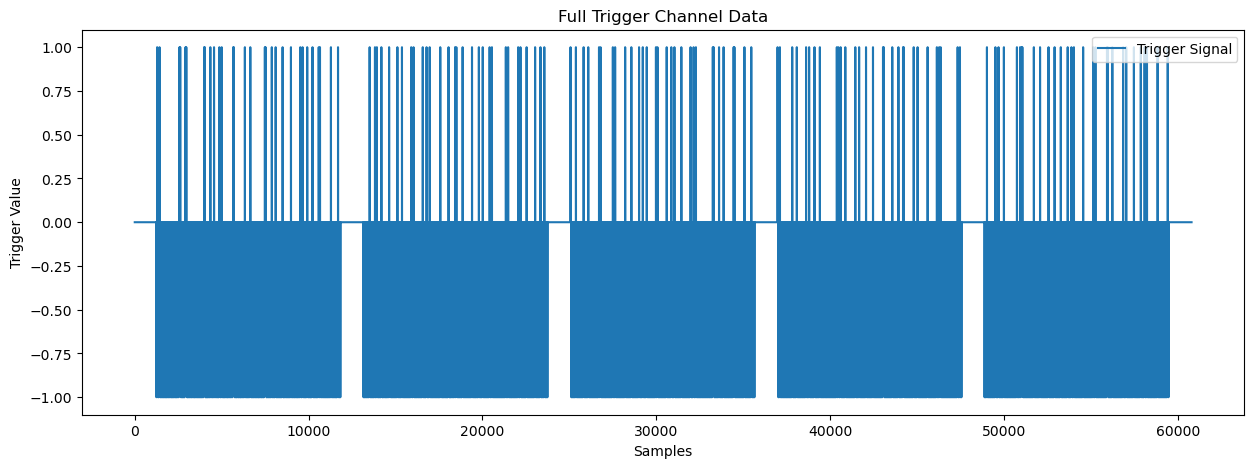

/var/folders/7b/c4vbtlw16ygd_nljcd9pgmvmxdhldg/T/ipykernel_39702/4261070876.py:77: RuntimeWarning: event 0 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)


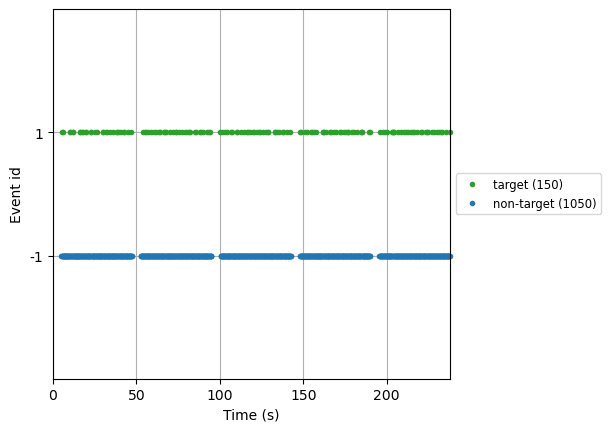

Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 226 original time points ...
0 bad epochs dropped
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 276 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
0 bad epochs dropped


In [2]:
import numpy as np
import scipy.io as sio
import mne
import matplotlib.pyplot as plt
from mne import pick_types

# Define functions for loading data, preprocessing, and artifact rejection
def load_data(file_path):
    mat_data = sio.loadmat(file_path)
    fs = mat_data['fs'][0, 0]  # Sampling frequency
    y = mat_data['y']  # EEG data
    trig = mat_data['trig'][:, 0]  # Ensure trig is 1D
    return y, trig, fs

def preprocess_eeg_data(y, trig, fs):
    ch_names = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
    info.set_montage('standard_1020')
    # create raw structure
    raw = mne.io.RawArray(y.T, info)
    # set the average reference
    raw.set_eeg_reference('average', projection=False)
    raw.filter(1., 30., fir_design='firwin')
    return raw, trig

def reject_artifacts(raw, trig, threshold=3.0):
    data = raw.get_data()
    stds = np.std(data, axis=0)
    mean_std = np.mean(stds)
    valid_indices = stds < mean_std * threshold
    
    cleaned_data = data[:, valid_indices]
    cleaned_trig = trig[valid_indices]
    cleaned_raw = mne.io.RawArray(cleaned_data, raw.info)
    return cleaned_raw, cleaned_trig

def reject_parameter(raw, events):
    picks = pick_types(raw.info, meg=True, eeg=True, stim=False)
    # Define event IDs
    event_id = {'non-target': -1, 'target': 1}
    dummy_epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=1.0,
                     picks=picks, baseline=(None, 0), preload=True,
                     reject=None)

    from autoreject import get_rejection_threshold  # noqa
    reject = get_rejection_threshold(dummy_epochs)
    return reject
    
def plot_full_trigger_data(trig):
    plt.figure(figsize=(15, 5))
    plt.plot(trig, label='Trigger Signal')
    plt.title('Full Trigger Channel Data')
    plt.xlabel('Samples')
    plt.ylabel('Trigger Value')
    plt.legend()
    plt.show()

# Load and preprocess the data
file_path = '/Users/diptyajit.das/Documents/p300/S4.mat'

y, trig, fs = load_data(file_path)
raw, trig = preprocess_eeg_data(y, trig, fs)

# Manually create events array from the cleaned triggers
event_times = np.where(np.diff(trig) != 0)[0] + 1  # Find changes in trigger values
event_values = trig[event_times]  # Get the trigger values at these times
events = np.column_stack((event_times, np.zeros_like(event_times), event_values))

# Plot full trigger data to understand its behavior
plot_full_trigger_data(trig)

# Define event IDs
event_id = {'non-target': -1, 'target': 1}

# Plot full trigger events for targets and non-targets
fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)

# Create epochs for ERP analysis
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=(None, 0), preload=True)

# get reject parameter
reject = reject_parameter(raw, events)

# clean
cleaned_epochs = epochs.drop_bad(reject)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Averaging across epochs...


/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


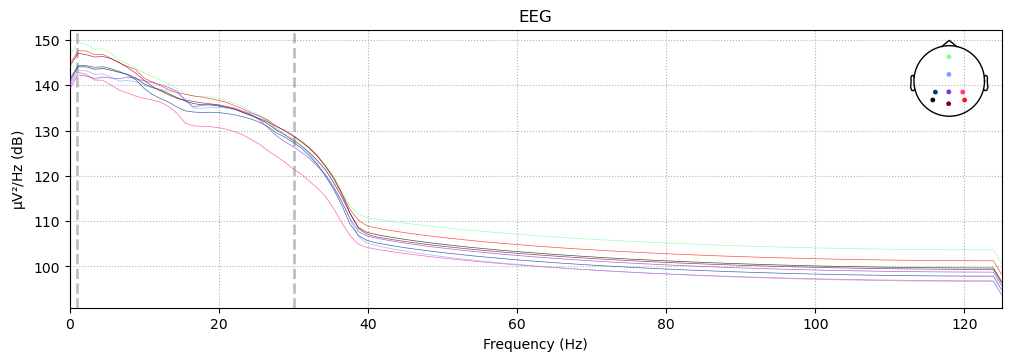

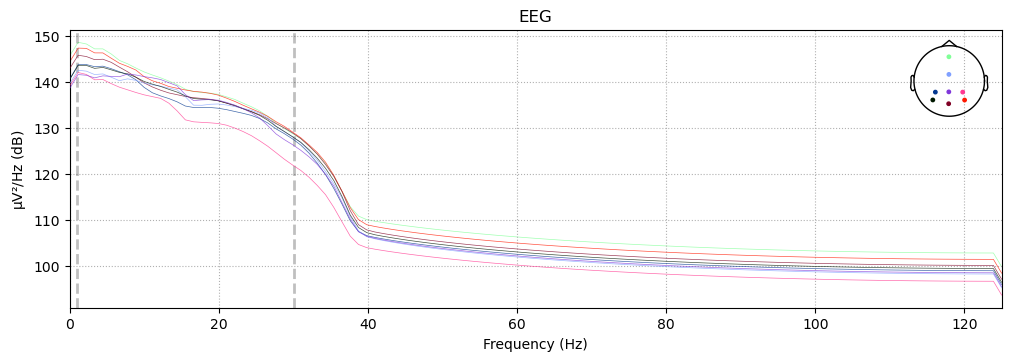

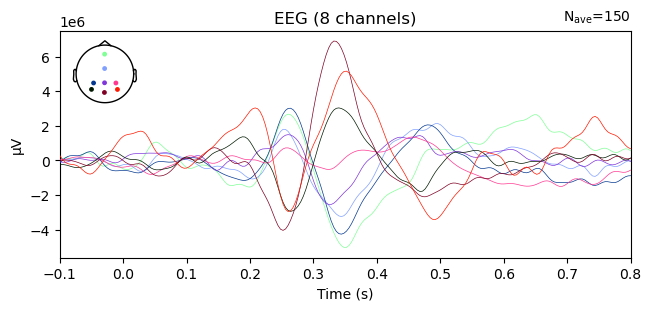

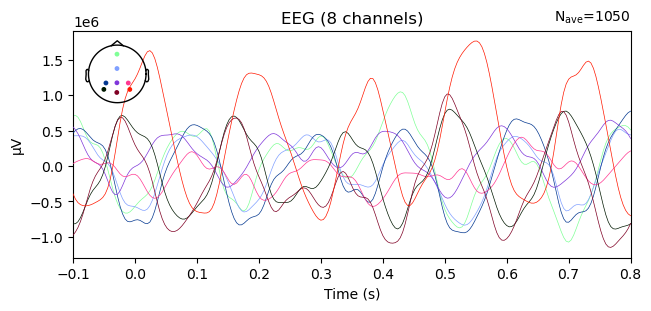

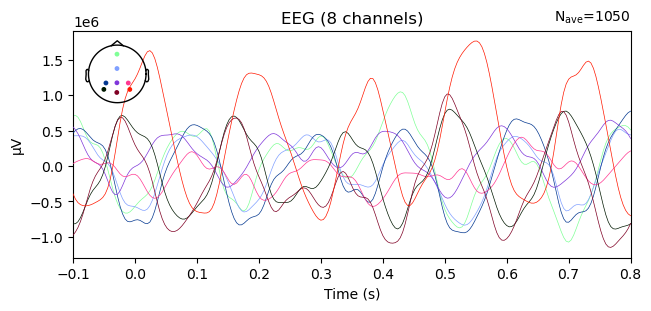

In [3]:
# Plot the Power Spectral Density 
psd_targets = cleaned_epochs['target'].plot_psd(show=True)
psd_nontargets = cleaned_epochs['non-target'].plot_psd(show=True)

# plot evoked signals
evoked_trg = cleaned_epochs['target'].average()
evoked_nontrg = cleaned_epochs['non-target'].average()
evoked_trg.plot()
evoked_nontrg.plot()

In [1]:
# Extract indices for targets and non-targets from previously cleaned trigger data
targets = np.where(cleaned_trig == 1)[0]
non_targets = np.where(cleaned_trig == -1)[0]

# Parameters for splits
n_splits = 20
test_size_targets = 10
test_size_non_targets = 70

# Storing indices of training and testing
splits = []

for _ in range(n_splits):
    # Shuffle the indices for randomness
    np.random.shuffle(targets)
    np.random.shuffle(non_targets)
    
    # Select test indices
    test_indices = np.concatenate((targets[:test_size_targets], non_targets[:test_size_non_targets]))
    train_indices = np.concatenate((targets[test_size_targets:], non_targets[test_size_non_targets:]))
    
    # Append to list
    splits.append((train_indices, test_indices))

# Output the indices for the first split as an example
splits[0]


NameError: name 'np' is not defined

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Reassessing the structure of the EEG data array to properly extract the samples
X_all = cleaned_raw.get_data().T  # Transposing to get correct orientation (samples x channels)

# Validate dimensions and data extraction process
n_samples, n_channels = X_all.shape

# Initialize lists to store metrics again
accuracies = []
classification_reports = []

# Loop through each split
for train_indices, test_indices in splits:
    # Ensure indices are within the range
    train_indices = [idx for idx in train_indices if idx < n_samples]
    test_indices = [idx for idx in test_indices if idx < n_samples]

    # Extract training and testing data
    X_train = X_all[train_indices, :]
    y_train = cleaned_trig[train_indices]
    X_test = X_all[test_indices, :]
    y_test = cleaned_trig[test_indices]
    
    # Define the model
    model = LogisticRegression(max_iter=1000, solver='liblinear')  # Using liblinear for binary classification
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test data
    predictions = model.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    
    # Generate a classification report
    report = classification_report(y_test, predictions, output_dict=True)
    classification_reports.append(report)

# Output average accuracy
average_accuracy = np.mean(accuracies)
average_accuracy


c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

0.875